In [1]:
# ╔═╡ 70122f72-ce57-11ed-34a3-edae52aeeea1
begin
	using Random
	using LinearAlgebra
	using Statistics: mean
end

# ╔═╡ 15481c8b-7a2a-46ae-bc99-86887b504106
begin
	using Plots
	using Flux
	using STFT
end

# ╔═╡ 9c2ef567-0e18-4b5a-ab99-b51c32cde693
using Flux: train!, mse

In [2]:
# ╔═╡ 03130321-be9c-4aaf-9b22-505d072fc565
begin
	# Generate notes for fake data set
	sample_rate = 44000. / 16. # 16th reduction from typical sample rate
	t = range(0, 1.5, step=1/sample_rate)
	f = 100; #Hz
end

# ╔═╡ 9a29e245-3124-4beb-abd6-085810af4c4f
begin
	# amplitude normalization slightly under 1 to avoid speaker clipping issues
	ceiling = 0.98
	normalized(y) =  y ./ maximum(abs.(y)) .* ceiling
end

# ╔═╡ 6fc6eb2a-44f8-4051-b95f-cb526dcc7404
function delay_note(y, t, delay)
    index = findfirst(t .>= delay)
    z = copy(y)
    z[index:end] = y[1:end-index+1]
    z[1:index-1] .= 0
    return z
end

# ╔═╡ 06d52688-756b-43ee-b73f-81a5d5426d56
function make_note(t, f₀; N=10, delay=0, ϕ=0)
    y = sum(exp.(-n*t).*sin.(2π*f₀*t*n .+ ϕ)/n for n ∈ 1:N) #N is number of harmonics
    if delay != 0
        y = delay_note(y, t, delay)
    end
    return normalized(y)
end

function make_held_note(t, f₀; N=10, ϕ=0)
    y = sum(sin.(2π*f₀*t*n .+ ϕ)/n for n ∈ 1:N) #N is number of harmonics
    return normalized(y)
end

# ╔═╡ 8e0661d1-990e-4e08-a09d-899112552abc
function arp_chord(t, notes, delays)
    y = sum(make_note(t,note,delay=delay) for (note,delay) ∈ zip(notes,delays))
    return normalized(y)
end

# ╔═╡ 3f357a03-d651-4343-a364-4524973a7f92
function hann(N::Int)
    N = N - N % 2 #makes sure N even
    n = 0:N
    return @. sin(π*n/N)^2
end

hann (generic function with 1 method)

In [3]:
# ╔═╡ b757cfa2-cf52-4555-9f5d-880f2f15d3b5
begin
	# Set seed
	Random.seed!(314)

	# STFT Parameters
	w = 250         # window width
	hop = w÷2 - 1   # number of samples to hop over
	window = hann(w)
	N = sample_rate÷2
	T = maximum(t)

	# Notes to be played, major triad has ratio 2:3:5
	notes = [100, 150, 250] #Hz
	
	# Matrix Sizes
	m, n = size(stft(t, window, hop))
	r = length(notes)
	freqs = range(0, N, m)
	times = range(0, T, n)

	# Dataset Sizes
	train_set_size = 10
	test_set_size  = 5

	# Number of Layers
	n_layers = 20
end

20

In [44]:
# ╔═╡ 1c64cd5c-7635-4b8d-ba1a-7b414c4391ad
function envelope(t, delay)
    ϵ = 0 #1e-4 #prevent divide by zero errors
    a = @. exp(-(t - delay)) * (t .>= delay)
    return @. a + (ϵ * (t < delay))
end

# ╔═╡ feda7445-89ed-4091-871a-f0467455a037
function make_VS()
    delays = [rand()*(T-0.5) for _ ∈ notes]
    #y = arp_chord(t,notes,delays)
    #V = abs.(stft(y, window, hop))
    H = vcat([envelope(times, delay)' for delay ∈ delays]...)
	W = hcat([abs.(stft(make_held_note(t,note), window, hop))[:,3] for note ∈ notes]...) #using 3 to remove end effects
	S = [w*h' for (w,h) ∈ zip(eachcol(W),eachrow(H))] #each note
	V = sum(S)
    return (V,S)
end

# ╔═╡ 5c03014b-8c96-47ec-aa6d-4ebd7081a212
begin #TODO change all the Hs to Ss
	# Make the datasets
	train = [make_VS() for _ ∈ 1:train_set_size]
	test  = [make_VS() for _ ∈ 1:test_set_size]
	train_S = [S for (_, S) ∈ train]
	train_V = [V for (V, _) ∈ train]
	test_S = [S for (_, S) ∈ test]
	test_V = [V for (V, _) ∈ test]
	data = zip(train_V, train_S)
	testing_data = zip(test_V, test_S)
end

zip([[0.0 0.0 … 0.007662554031592091 0.007288846861676971; 0.0 0.0 … 0.008246982209423149 0.007844772140937208; … ; 0.0 0.0 … 1.134293053433224 1.0789729284324434; 0.0 0.0 … 0.10847453448767291 0.10318416901369197], [0.0 0.0 … 0.005633243622007226 0.005358507088634251; 0.0 0.0 … 0.006010872424791483 0.005717718717381613; … ; 0.0 0.0 … 1.1614918132147902 1.1048451890465956; 0.0 0.0 … 0.11106915544531468 0.10565224881402702], [0.0 0.0 … 0.007509838496260133 0.0071435793508908335; 0.0 0.0 … 0.0081297731378966 0.007733279423282746; … ; 0.0 0.0 … 0.8051887821551502 0.7659192618638742; 0.0 0.0 … 0.0770164305372007 0.07326029489700062], [0.0 0.0 … 0.005388971015831783 0.005126147798040694; 0.0 0.0 … 0.005757357748986991 0.005476568098213621; … ; 0.0 0.0 … 1.061334425672386 1.0095725349351394; 0.0 0.0 … 0.10149662327672368 0.09654657454828364], [0.0 0.0 … 0.00720496972703052 0.006853579206988308; 0.0 0.0 … 0.0076908763844896755 0.007315787917124244; … ; 0.0 0.0 … 1.460956331267018 1.3897046502

In [15]:
delays = [rand()*(T-0.5) for _ ∈ notes]
H = vcat([envelope(times, delay)' for delay ∈ delays]...)

3×31 Matrix{Float64}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0       …  0.462991  0.440411  0.418932
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0          0.474481  0.45134   0.429328
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.961442     0.336445  0.320036  0.304428

In [11]:
W = hcat([abs.(stft(make_held_note(t,note), window, hop))[:,3] for note ∈ notes]...)

126×3 Matrix{Float64}:
  0.00821214  0.00714554  0.00064359
  0.00903499  0.00743246  0.00069267
  0.0118354   0.00833186  0.000827961
  0.0179154   0.00997721  0.00102966
  0.0309054   0.0126539   0.00128789
  0.0618279   0.016921    0.00160442
  0.153594    0.0238795   0.00199028
  0.581707    0.0358184   0.00246527
 15.1739      0.0579656   0.00305969
 36.6987      0.10403     0.00381879
  ⋮                       
  4.83965e-5  0.0196458   0.00850089
  4.09219e-5  0.00952341  0.00344452
  3.42201e-5  0.0110338   0.00175813
  2.81405e-5  0.0254247   0.00102029
  2.25623e-5  0.0915764   0.000637425
  1.73939e-5  1.41857     0.000412581
  1.25842e-5  4.00227     0.000267076
  8.18899e-6  2.72754     0.000166847
  4.77505e-6  0.260766    0.000104585

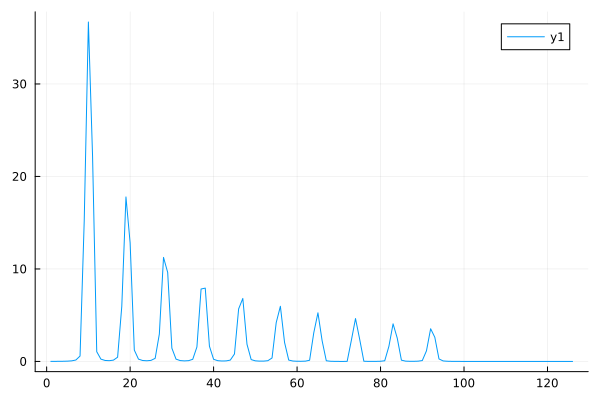

In [19]:
plot(W[:,1])

In [46]:
V,S = train[1]

([0.0 0.0 … 0.00899920476134839 0.008560308366101515; 0.0 0.0 … 0.009621918388558514 0.009152651891341353; … ; 0.0 0.0 … 1.7317288387226821 1.647271426649467; 0.0 0.0 … 0.1656017638347624 0.1575252705088442], [[0.0 0.0 … 0.0041867815794262905 0.003982589832307861; 0.0 0.0 … 0.004606298659085898 0.004381646822560689; … ; 0.0 0.0 … 4.17498149613493e-6 3.9713652458695605e-6; 0.0 0.0 … 2.4344566218023353e-6 2.315726771328988e-6], [0.0 0.0 … 0.004536543807248864 0.004315293954991615; 0.0 0.0 … 0.004718702234875135 0.004488568411270508; … ; 0.0 0.0 … 1.7316531436715492 1.6471994232895402; 0.0 0.0 … 0.16555449848824808 0.15748031032048054], [0.0 0.0 … 0.00027587937467323686 0.00026242457880203997; 0.0 0.0 … 0.0002969174945974793 0.0002824366575101541; … ; 0.0 0.0 … 7.152006963692785e-5 6.803199468098587e-5; 0.0 0.0 … 4.4830889892537374e-5 4.2644461592333204e-5]])

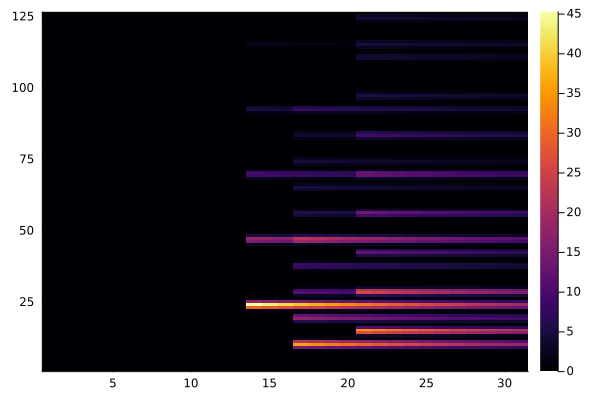

In [48]:
heatmap(sum(Si for Si ∈ S))

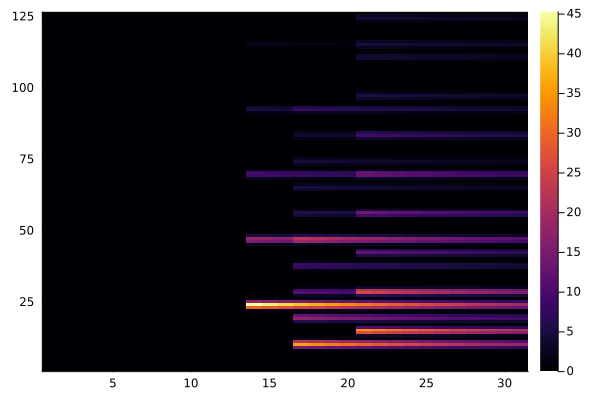

In [47]:
heatmap(V)

In [30]:
# ╔═╡ 01c584d6-b102-431d-bc05-f43d8f60d36c
# Define the ALS NN Layer
ReLU(x) = max.(x, 0)

struct MyLayer
    W
end

W_init = abs.(randn((m,r))) #use the same random initialization
function MyLayer(m,r)
    W = W_init
    MyLayer(W)
end

function (a::MyLayer)((H, V))
    W = a.W #force the matrix to be positive
    ϵ = 1e-6 #avoid divide by zero problems, equivilent to adding an L1 regularizer
    λ = 0#1e-1 # adds an L2 regularizer to the minimization 1/2|V-WH|+ϵ|H|₁+λ/2|H|₂^2
    #return (H .* (W'*V) ./ (W'*W*H .+ ϵ + λ.*H), V) #one update step
    return (H .* (W'*V) ./ (W'*W*H .+ ϵ + λ.*H), V)
end

Flux.@functor MyLayer (W,) #declare the weights W as trainable parameters

In [32]:
# Define the model
struct MyModel
	chain::Chain
end
H_init = abs.(randn((r,n))) 
function (m::MyModel)(V::Matrix{Float64})
	#H_init = W \ V # Least Squares Initialization
	(H, _) = m.chain((H_init, V))
	W = Flux.params(m)[1]
	S = [w*h' for (w,h) ∈ zip(eachcol(W),eachrow(H))] #reconstruct every source
	return S
end

function (m::MyModel)(V::Vector{Matrix{Float64}})
	return m.(V) #apply m to all elements in V
end
	
Flux.@functor MyModel

In [33]:
# ╔═╡ 6e567463-2b84-4472-9fa6-050e2e97d4ce
begin
	# Create the NN
	my_layer = MyLayer(m,r)
	chain = Chain([my_layer for _ ∈ 1:n_layers]) # shared parameters
	#chain = Chain([MyLayer(m,r) for _ ∈ 1:n_layers]) # different parameters
	model = MyModel(chain)
end

# ╔═╡ 32f07151-5b8c-4412-a3f3-b85515d93fa9
model(train_V[1])

# ╔═╡ fd523a2f-cde6-4b2f-977f-bc32ea9c6dfb
Flux.params(model)

Params([[0.7353373511043719 0.48500540786362156 0.7858688585922772; 0.047656057202358736 0.4234914002184602 0.36657294507641486; … ; 1.0758986399910522 0.8233540455527294 1.5845862914594002; 0.813032140874019 0.658073006070456 0.7400539375329258]])

In [49]:
# ╔═╡ f719af93-5fd5-4690-b9d4-9ba5852b5f6d
function loss(model, V_input, S_truth)
    S_output = model(V_input)
    return sum(mse(S1, S2) for (S1,S2) ∈ zip(S_output, S_truth))
end

# ╔═╡ fa4f0aa7-07d4-4960-b4e8-86a8e1d9e51b
opt = Descent()

# ╔═╡ af0b1669-f09c-430a-823c-2501fa6104e1
#train!(loss, model, data, opt)

# ╔═╡ 572e17af-3a5a-42e1-a790-9c545e202ae4
function my_train(maxit=50)
    train_test_ratio = 1#train_set_size/test_set_size
    training_loss = zeros(1,maxit)
    testing_loss  = zeros(1,maxit)
    for i ∈ 1:maxit
        println("i = ",i)
        train!(loss, model, data, opt)
        training_loss[i] = mean(loss(model, V, H) for (V,H) ∈ data)
        testing_loss[i]  = mean(loss(model, V, H) for (V,H) ∈ testing_data)
    end
    return training_loss, testing_loss*train_test_ratio
end

my_train (generic function with 2 methods)

In [50]:
train!(loss, model, data, opt)

In [61]:
maxit = 5#50
training_loss, testing_loss = my_train(maxit)

([10.508598366121477 5.645077855454012 … 0.9895640744025288 0.38638446316807407], [10.75868259890468 5.75213268485353 … 0.996253690407573 0.3871938040431317])

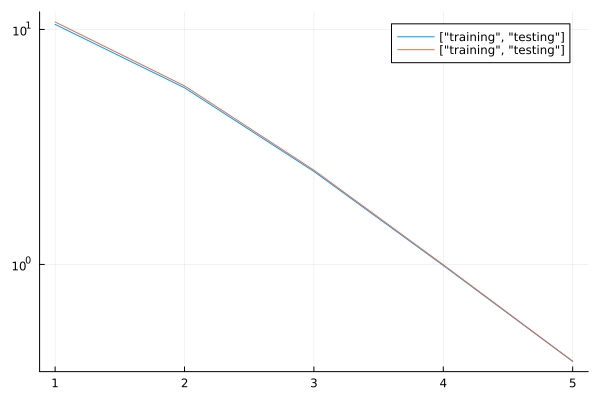

In [62]:
# ╔═╡ 08987c7d-2029-4be0-8e49-9e92b4912477
plot(1:maxit,[training_loss',testing_loss'],label=["training", "testing"], yscale=:log10)

In [65]:
# ╔═╡ 7ab02d01-7201-42eb-825f-0e9516cddecd
learned_W = abs.(Flux.params(model)[1])

# ╔═╡ cdd94d93-deaa-4ff5-a78f-ee76b61b2f72
function plot_Ws(W)
	p1 = plot(freqs,W[:,1], color=:blue, label = "w1")
	p2 = plot(freqs,W[:,2], color=:red, label = "w2")
	p3 = plot(freqs,W[:,3], color=:green, label = "w3", xlabel = "frequency (Hz)")
	plot(p1,p2,p3, layout=(r,1))
	plot!(xticks=0:100:1400)
end

# ╔═╡ 89305234-16cb-4704-9a11-dcf5db583ae8
function plot_Hs(H)
	p1 = plot(times,H[1,:], color=:blue, label = "h1")
	p2 = plot(times,H[2,:], color=:red, label = "h2")
	p3 = plot(times,H[3,:], color=:green, label = "h3", xlabel = "time (s)")
	plot(p1,p2,p3, layout=(r,1))
end

plot_Hs (generic function with 1 method)

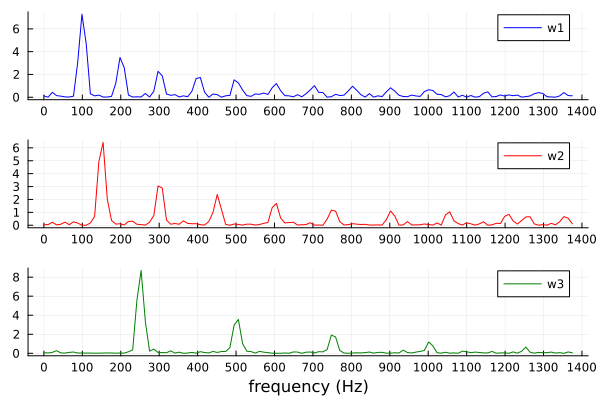

In [66]:
# ╔═╡ 182c37b5-80c9-4a82-95e2-957859fa93b9
plot_Ws(learned_W)

In [ ]:
# ╔═╡ c1e6d11f-0b80-464e-96ce-cba6e3ef37a0
#plot_Hs(model(train_V[1])[1])

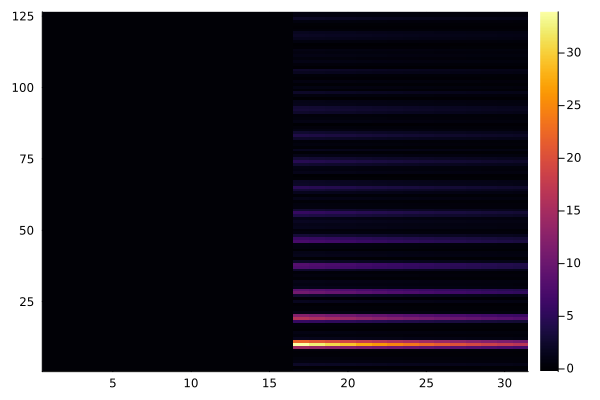

In [64]:
heatmap(model(train_V[1])[1])

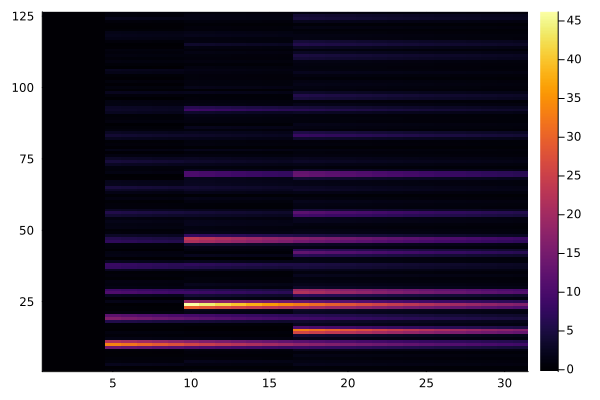

In [67]:
heatmap(sum(model(train_V[4])))

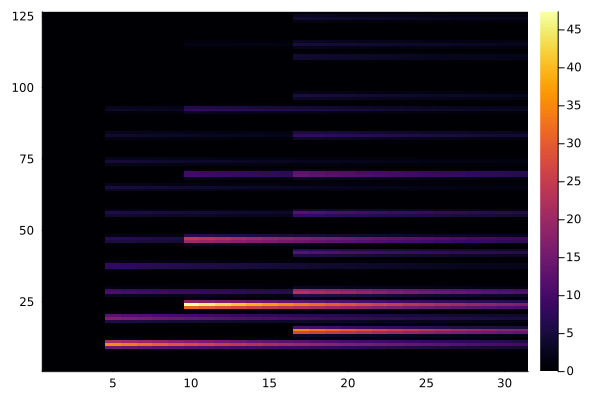

In [68]:
heatmap(train_V[4])

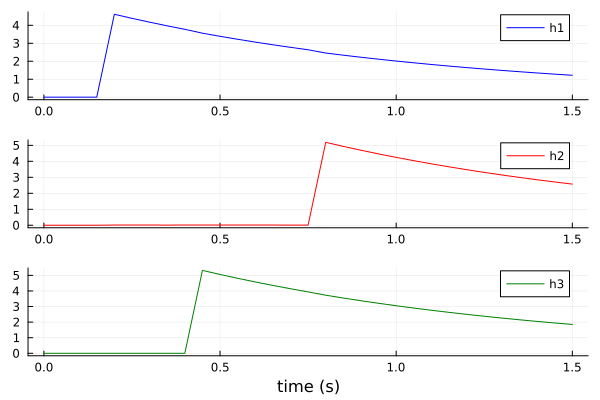

In [71]:
(H, _) = model.chain((H_init, train_V[4]))
plot_Hs(H)